In [1]:
%matplotlib inline


==========================
# Image Inpainting with PCA
Qiqi ZHOU, qzhouam@connect.ust.hk

==========================


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
  
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
print(X_digits.shape, y_digits.shape)

Automatically created module for IPython interactive environment
(1797, 64) (1797,)


In [2]:
# show digits in datasets.load_digits() as an image , and print the corresponding label from datasets.load_digits().target
def show_digits(images, targets,title=None, n_row=4, n_col=4,sub_title_size=32):
    fig = plt.figure()
    for i in range(n_row * n_col):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        # give more space between subplots
        fig.subplots_adjust( wspace=-0.4)
        # close the axis
        ax.axis('off')
        ax.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % targets[i], fontsize=8)
    if title:
        plt.suptitle(title, size=sub_title_size)
        # hspace for sup title
        if sub_title_size==32:
            plt.subplots_adjust(top=0.8)

# show_digits(digits.images, digits.target, title='RAW digits', n_row=2, n_col=2,sub_title_size=16)

In [42]:
# middle row broken image and digit
def broken_middle_row(images, broken_row_list):
    broken_images_middle_row = np.copy(images)
    broken_images_middle_row[:,broken_row_list,:] = 0
    broken_digits_middle_row = broken_images_middle_row.reshape(len(broken_images_middle_row), -1)
    return broken_images_middle_row, broken_digits_middle_row
def broken_middle_col(images, broken_col_list):
    broken_images_middle_col = np.copy(images)
    broken_images_middle_col[:,:,broken_col_list] = 0
    broken_digits_middle_col = broken_images_middle_col.reshape(len(broken_images_middle_col), -1)
    return broken_images_middle_col, broken_digits_middle_col

broken_row_list = [4,5]
broken_col_list = [4,5]
# # show 16 broken images
# show_digits(broken_middle_row(digits.images, broken_row_list)[0], digits.target, title='Broken middle row', n_row=2, n_col=2,sub_title_size=16)
# show_digits(broken_middle_col(digits.images, broken_col_list)[0], digits.target, title='Broken middle col', n_row=2, n_col=2,sub_title_size=16)
# show_digits(broken_middle_row(broken_middle_col(digits.images, broken_col_list)[0], broken_row_list)[0], digits.target, title='Broken cross', n_row=2, n_col=2,sub_title_size=16)

In [4]:
# distance matrix of digits
def distance_matrix(X1, X2=None):
    if X2 is None:
        X2 = X1
    X1_norm = (X1 ** 2).sum(axis=1).reshape(-1, 1)
    X2_norm = (X2 ** 2).sum(axis=1).reshape(1, -1)
    distance_matrix = X1_norm + X2_norm - 2 * np.dot(X1, X2.T)
    return distance_matrix

# show distance matrix of digits
def show_distance_matrix(X_distance_matrix):
    plt.matshow(X_distance_matrix, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title('Distance matrix of digits')
    plt.show()

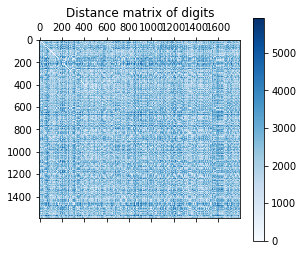

query digit is:  label[[111]]=[4]
most similar digit to the broken middle row digit is:  [ 403  413  447 ...  818 1747 1117]


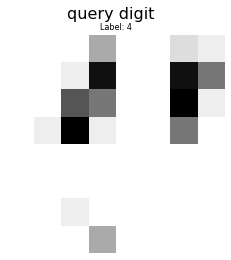

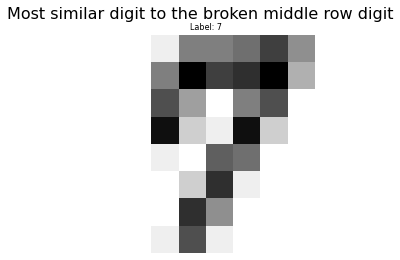

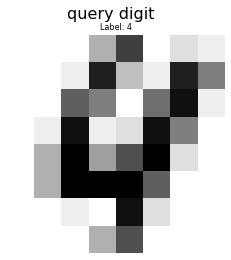

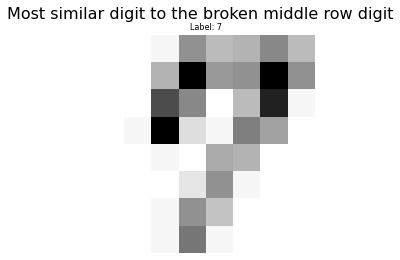

In [43]:
test_size = 200
raw_train_images, raw_train = digits.images[:-test_size], digits.data[:-test_size]
raw_test_images, raw_test = digits.images[-test_size:], digits.data[-test_size:]

broken_row_test_images, broken_row_test = [v[-test_size:] for v in broken_middle_row(digits.images, broken_row_list)]
broken_col_test_images, broken_col_test = [v[-test_size:] for v in broken_middle_col(digits.images, broken_col_list)]
broken_cross_test_images, broken_cross_test = [v[-test_size:] for v in broken_middle_row(broken_middle_col(digits.images, broken_col_list)[0], broken_row_list)]

raw_self_distance_matrix = distance_matrix(raw_train, digits.data)
row_raw_distance_matrix = distance_matrix(broken_row_test, digits.data)
col_raw_distance_matrix = distance_matrix(broken_col_test, digits.data)
cross_raw_distance_matrix = distance_matrix(broken_cross_test, digits.data)

show_distance_matrix(raw_self_distance_matrix)

# find the most similar digit to the broken middle row digit, and show as an image
def find_most_similar_digit(X_distance_matrix, query, k=1):
    most_similar_digits = np.argsort(X_distance_matrix[query])[:k]
    return most_similar_digits


# anchor_type = "row"
anchor_type = "cross"
anchor_idx = [111]
anchor_raw_distance_matrix = eval(anchor_type + "_raw_distance_matrix")
anchor_images = eval("broken_" + anchor_type + "_test_images")

most_similar_digits = find_most_similar_digit(anchor_raw_distance_matrix, query=anchor_idx, k=1)[0]
print('query digit is: ', f'label[{anchor_idx}]={digits.target[anchor_idx]}')
print('most similar digit to the broken middle row digit is: ', most_similar_digits)
show_digits(anchor_images[anchor_idx], digits.target[-test_size:][anchor_idx], title='query digit', n_row=1, n_col=1,sub_title_size=16)
show_digits(digits.images[most_similar_digits], digits.target[most_similar_digits], title='Most similar digit to the broken middle row digit', n_row=1, n_col=1,sub_title_size=16)
# 
show_digits(raw_test_images[anchor_idx], digits.target[-test_size:][anchor_idx], title='query digit', n_row=1, n_col=1,sub_title_size=16)
show_digits((digits.images[most_similar_digits]+anchor_images[anchor_idx])/2, digits.target[most_similar_digits], title='Most similar digit to the broken middle row digit', n_row=1, n_col=1,sub_title_size=16)


In [81]:
# sparse PCA
sparse_pca = decomposition.SparsePCA(alpha=0.1, n_components=64)
X_spca = sparse_pca.fit_transform(raw_train)


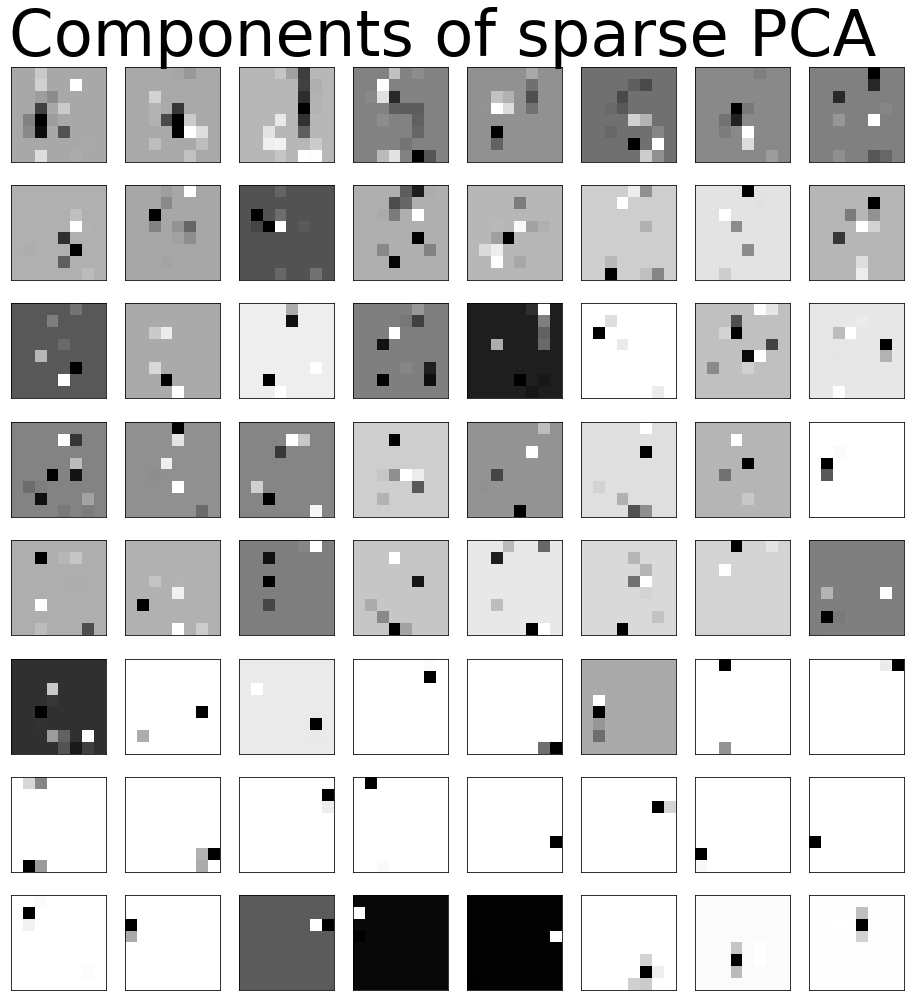

In [100]:
# show components of sparse pca
def show_components(components, n_row=2, n_col=2, title='Components', sub_title_size=16):
    plt.figure(figsize=(n_col * 2, n_row * 2))
    plt.suptitle(title, fontsize=sub_title_size)
    # hspace of suptitle    
    plt.subplots_adjust(top=0.93)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(components[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

show_components(sparse_pca.components_, n_row=8, n_col=8, title='Components of sparse PCA',sub_title_size=64)



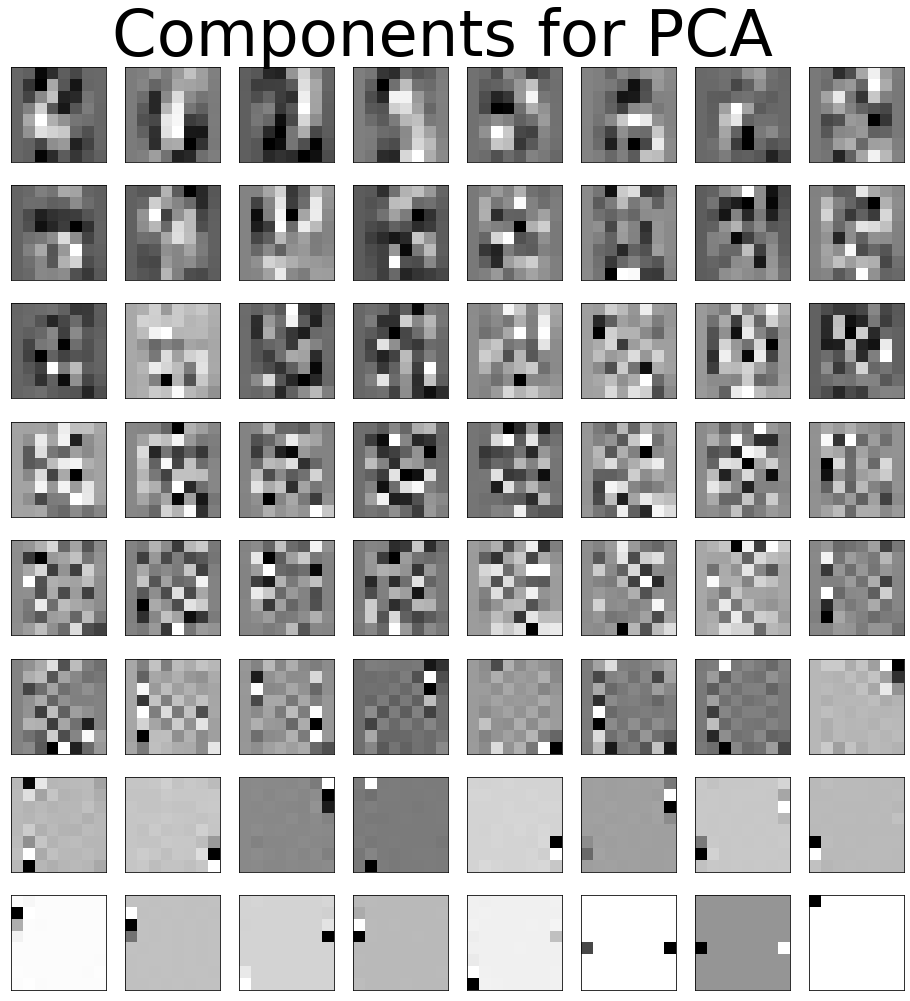

find the 0.99 ratio:  40
sum of ratio:  1.0


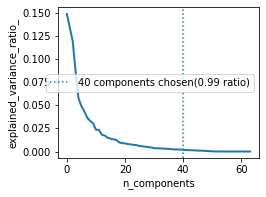

In [115]:
# PCA
pca = decomposition.PCA()
X_pca_train = pca.fit_transform(raw_train)
X_pca_test = pca.transform(raw_test)
# show components of pca
show_components(pca.components_, n_row=8, n_col=8, title='Components for PCA',sub_title_size=64)

# find the 0.95 ratio
ratio_threshold = 0.99
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) > ratio_threshold)[0][0]
print(f"find the {ratio_threshold} ratio: ", n_components)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
# notation for plt.axvline
plt.axvline(n_components, linestyle=':', label=f'{n_components} components chosen({ratio_threshold} ratio)')
plt.legend(prop=dict(size=10))
print("sum of ratio: ", sum(pca.explained_variance_ratio_))


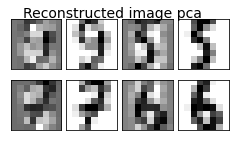

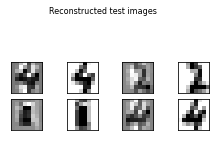

In [199]:
# only use the first n_components components to reconstruct the image
def reconstruct_image(X_pca, components, n_components):
    X_reconstruct = np.dot(X_pca[:, :n_components], components[:n_components, :])
    return X_reconstruct

# show the reconstructed image
def show_reconstruct_image(X_reconstruct, X_test_images, n_row=2, n_col=2, title='Reconstructed image', sub_title_size=16, process=False, refer_images=None,supplot_adjust=0.8,subplot_wspace=-0.8): 
    plt.figure(figsize=(n_col * 2, n_row))
    plt.suptitle(title, fontsize=sub_title_size)
    # hspace of suptitle
    plt.subplots_adjust(top=supplot_adjust)
    # wspace of subplots
    def process_X_reconstruct(X_reconstruct, low_threshold=0.1,high_threshold=0.1):
        X_reconstruct_copy = X_reconstruct.copy()
        # assgin the value smaller than threshold*max to zero
        if process:
            X_reconstruct_copy[X_reconstruct < low_threshold * np.max(X_reconstruct)] *= 0.5
            X_reconstruct_copy[X_reconstruct > high_threshold * np.max(X_reconstruct)] *= 1.5
        return X_reconstruct_copy
    random_idx = np.random.randint(0, len(X_reconstruct), n_row * n_col)
    if refer_images is not None:
        col_base_num = 3
    else:
        col_base_num = 2
    for i in range(n_row * n_col//col_base_num):
        plt.subplot(n_row, n_col, i*col_base_num + 1)
        plt.imshow(process_X_reconstruct(X_reconstruct[random_idx[i]]).reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.subplot(n_row, n_col, i*col_base_num + 2)
        plt.imshow(X_test_images[random_idx[i]].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        if refer_images is not None:
            plt.subplot(n_row, n_col, i*col_base_num + 3)
            plt.imshow(refer_images[random_idx[i]].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
    plt.subplots_adjust(wspace=subplot_wspace)
    # plt.title(title, fontsize=sub_title_size)
    plt.show()

show_reconstruct_image(reconstruct_image(X_pca_train, pca.components_, n_components), raw_train_images, n_row=2, n_col=4, title='Reconstructed image pca', sub_title_size=14,supplot_adjust=0.9)
show_reconstruct_image(reconstruct_image(X_pca_test, pca.components_, n_components), raw_test_images, n_row=2, n_col=4, title='Reconstructed test images', sub_title_size=8,supplot_adjust=0.6)

In [200]:
# X_pca_train shape
selected_X_pca_train = X_pca_train[:, :n_components]
print("selected_X_pca_train.shape: ", selected_X_pca_train.shape)

from sklearn.cluster import KMeans
use_element_wise_kmeans = False
if use_element_wise_kmeans:
    # cluster X_pca_train to 10 clusters in for elements in second dimension
    kmeans_dictionary = []
    for i in range(selected_X_pca_train.shape[1]):
        kmeans = KMeans(n_clusters=50, random_state=0).fit(selected_X_pca_train[:, [i]])
        kmeans_dictionary.append(kmeans)

    # get the cluster centers
    cluster_centers = []
    for kmeans in kmeans_dictionary:
        cluster_centers.append(kmeans.cluster_centers_)
    cluster_centers = np.array(cluster_centers)
    print(cluster_centers.shape)
else:
    # cluster X_pca_train to 10 clusters
    kmeans = KMeans(n_clusters=100, random_state=0).fit(selected_X_pca_train)
    cluster_centers = kmeans.cluster_centers_
    print(cluster_centers.shape)

selected_X_pca_train.shape:  (1597, 40)
(100, 40)


In [201]:
X_pca_test_broken_row = pca.transform(broken_col_test)[:,:n_components]
X_pca_test_broken_col = pca.transform(broken_row_test)[:,:n_components]
X_pca_test_broken_cross = pca.transform(broken_cross_test)[:,:n_components]
print("X_pca_test_broken_row.shape: ",X_pca_test_broken_row.shape)

X_pca_test_broken_row.shape:  (200, 40)


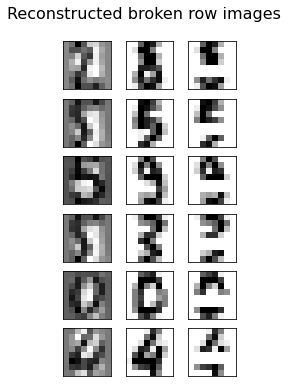

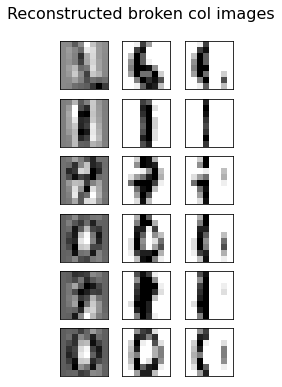

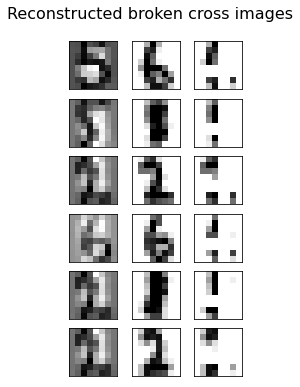

In [221]:
def fix_broken_image(X_pca_test_broken, kmeans_dictionary, n_components):
    fixed_X_pca_test_broken = X_pca_test_broken.copy()
    for i in range(fixed_X_pca_test_broken.shape[0]):
        for j in range(n_components):
            fixed_X_pca_test_broken[i][j] = kmeans_dictionary[j].predict([[fixed_X_pca_test_broken[i][j]]])
    return fixed_X_pca_test_broken
if use_element_wise_kmeans:
    fixed_X_pca_test_broken_row = fix_broken_image(X_pca_test_broken_row, kmeans_dictionary, n_components)
    fixed_X_pca_test_broken_col = fix_broken_image(X_pca_test_broken_col, kmeans_dictionary, n_components)
    fixed_X_pca_test_broken_cross = fix_broken_image(X_pca_test_broken_cross, kmeans_dictionary, n_components)
else:
    fixed_X_pca_test_broken_row = cluster_centers[kmeans.predict(X_pca_test_broken_row)]
    fixed_X_pca_test_broken_col = cluster_centers[kmeans.predict(X_pca_test_broken_col)]
    fixed_X_pca_test_broken_cross = cluster_centers[kmeans.predict(X_pca_test_broken_cross)]

show_reconstruct_image(reconstruct_image(fixed_X_pca_test_broken_row, pca.components_, n_components), raw_test_images, n_row=6, n_col=3, title='Reconstructed broken row images', sub_title_size=16, refer_images=broken_row_test, supplot_adjust=0.9, subplot_wspace=-0.7)
show_reconstruct_image(reconstruct_image(fixed_X_pca_test_broken_col, pca.components_, n_components), raw_test_images, n_row=6, n_col=3, title='Reconstructed broken col images', sub_title_size=16, refer_images=broken_col_test, supplot_adjust=0.9, subplot_wspace=-0.7)
show_reconstruct_image(reconstruct_image(fixed_X_pca_test_broken_cross, pca.components_, n_components), raw_test_images, n_row=6, n_col=3, title='Reconstructed broken cross images', sub_title_size=16, refer_images=broken_cross_test, supplot_adjust=0.9, subplot_wspace=-0.7)

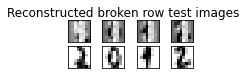

In [145]:
show_reconstruct_image(reconstruct_image(X_pca_test_broken_row, pca.components_, n_components), raw_test_images, n_row=1, n_col=4, title='Reconstructed broken row test images', sub_title_size=12)